# Coding Assignment 1

### CS 598
Nathan Fitzpatrick (johnnf2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.style as style
import random
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

## Function to generate data

In [3]:
def generate_data(ntrain, ntest,nclusters = 10,p = 2, s = 1):
    
    m1 = np.random.normal(size = (nclusters, p)) * s \
         + np.concatenate([np.array([[1, 0]] * nclusters)])
    m0 = np.random.normal(size = (nclusters, p)) * s \
         + np.concatenate([np.array([[0, 1]] * nclusters)])
     
    
    # Randomly allocate the n samples for class 1  to the 10 clusters
    id1 = np.random.randint(nclusters, size = ntrain)
    id0 = np.random.randint(nclusters, size = ntrain)
    
    
    # sd for generating x  
    s = np.sqrt(float(1)/5) 
    
    traindata = np.random.normal(size = (2 * ntrain, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    ytrain = np.concatenate(([1]*ntrain, [0]*ntrain))
    
    id1 = np.random.randint(nclusters, size = ntest)
    id0 = np.random.randint(nclusters, size = ntest)
    
    
    testdata = np.random.normal(size = (2 * ntest, p)) * s \
                + np.concatenate([m1[id1,:], m0[id0,:]])
    ytest = np.concatenate(([1]*ntest, [0]*ntest))
    
    return traindata, ytrain, testdata, ytest, m1, m0

## Function for plotting data

In [4]:
def plot_scatter_data(data, m1, m0):
    traindata = data
    plt.scatter(traindata[:ntrain, 0], traindata[:ntrain, 1], c = "blue", alpha=0.2, label='Class 1')
    plt.scatter(traindata[ntrain:, 0], traindata[ntrain:, 1], c = "red", alpha=0.2, label='Class 0')
    
    plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
    plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")
    
    plt.legend()
    plt.show()


## Linear Regression

In [5]:
def linear_regression(traindata, testdata, ytrain, ytest, ntrain, ntest):
    RegModel = lm.LinearRegression()
    RegModel.fit(traindata, ytrain)
    
    Ytrain_pred_LS = RegModel.predict(traindata)
    Ytest_pred_LS = RegModel.predict(testdata)
    
    Ytrain_pred_LS = [1 if i >= 0.5 else 0 for i in Ytrain_pred_LS]
    Ytest_pred_LS = [1 if i >= 0.5 else 0 for i in Ytest_pred_LS]
    
    train_err_LS = sum(ytrain != Ytrain_pred_LS) / float(2*ntrain)
    test_err_LS = sum(ytest != Ytest_pred_LS) / float(2*ntest)
    return train_err_LS, test_err_LS

## Quadratic Regression

In [6]:
def quadratic_regression(traindata, testdata, ytrain, ytest, ntrain, ntest):
    QuadModel = Pipeline([('poly', PolynomialFeatures(degree=2)),
                          ('linear', lm.LinearRegression(fit_intercept=False))])
    
    QuadModel.fit(traindata, ytrain)
    
    Ytrain_pred_QM = QuadModel.predict(traindata)
    Ytest_pred_QM = QuadModel.predict(testdata)
    
    Ytrain_pred_QM = [1 if i >= 0.5 else 0 for i in Ytrain_pred_QM]
    Ytest_pred_QM = [1 if i >= 0.5 else 0 for i in Ytest_pred_QM]
    
    train_err_QM = sum(ytrain != Ytrain_pred_QM) / float(2*ntrain)
    test_err_QM = sum(ytest != Ytest_pred_QM) / float(2*ntest)
    return train_err_QM, test_err_QM


## KNN Classifier

In [7]:
def knn_classifier(traindata, ytrain, testdata, ytest):
    myk = [20, 17, 15, 13, 11, 9, 7, 5, 3, 1]
    mykError = []
    
    rng = np.random.default_rng()
    trainDataShuffle = np.hstack((traindata,ytrain.reshape(-1,1)))
    rng.shuffle(trainDataShuffle)   
    foldNum = 10
    foldSize = int(np.floor(len(trainDataShuffle)/foldNum))
    foldIndex = np.zeros(trainDataShuffle.shape)
    
    for j in myk:
        myknn = knn(n_neighbors = j)
        error = 0
        
        for fold in range(foldNum): 
            foldIndex[foldSize*fold:foldSize*(fold+1),:] = 1
            trainX = trainDataShuffle[foldIndex==1].reshape(-1,3)[:,0:2]
            trainY = trainDataShuffle[foldIndex==1].reshape(-1,3)[:,2]
            testX = trainDataShuffle[foldIndex==0].reshape(-1,3)[:,0:2]
            testY = trainDataShuffle[foldIndex==0].reshape(-1,3)[:,2]
            
            myknn.fit(trainX, trainY)
            predY = myknn.predict(testX)
            errorKNN = np.zeros(predY.shape)
            errorKNN[testY!=predY] = 1
            error += sum(errorKNN)
            foldIndex.fill(0)
    
        error /= (trainDataShuffle.shape[0]*foldNum)
        mykError.append(error)
    
    chosen_k = myk[np.argmin(mykError)]
    myknn = knn(n_neighbors = chosen_k)
    myknn.fit(traindata, ytrain)
    
    train_err_KNN = (1 - myknn.score(traindata, ytrain))
    test_err_KNN = (1- myknn.score(testdata, ytest))
    return train_err_KNN, test_err_KNN, chosen_k

## Bayes Classifier

In [8]:
def bayes_classifier(traindata, testdata, ytrain, ytest, m1, m0, ntrain, ntest):
    def bayes(x):
        m1sum = np.square(m1-x)
        m1sum = np.sum(m1sum,axis=1)
        m1sum = np.exp(-5*m1sum/2)
        m1sum = np.sum(m1sum)
        
        m0sum = np.square(m0-x)
        m0sum = np.sum(m0sum,axis=1)
        m0sum = np.exp(-5*m0sum/2)
        m0sum = np.sum(m0sum)
        return m1sum/m0sum
    
    Ytrain_pred_Bayes = [int(bayes(x) > 1) for x in traindata]
    Ytest_pred_Bayes = [int(bayes(x) > 1) for x in testdata]
    
    train_err_Bayes = sum(ytrain !=  Ytrain_pred_Bayes) / float(2*ntrain)
    test_err_Bayes = sum(ytest !=  Ytest_pred_Bayes) / float(2*ntest)
    
    return train_err_Bayes, test_err_Bayes

### Main code that generates data and calls each classification function 20 times. 

In [15]:
ntrain=100
ntest=5000
random.seed(6380)
classification_errors = []
bestKs = []


for i in range(20):
    traindata, ytrain, testdata, ytest, m1, m0 = generate_data(ntrain, ntest, nclusters = 10, p = 2, s = 1)
    
    train_error, test_error = linear_regression(traindata, testdata, ytrain, ytest, ntrain, ntest)
    classification_errors.append({'method':'linear','set':'train', 'error':train_error})
    classification_errors.append({'method':'linear','set':'test', 'error':test_error})
    
    train_error, test_error = quadratic_regression(traindata, testdata, ytrain, ytest, ntrain, ntest)
    classification_errors.append({'method':'quadratic','set':'train', 'error':train_error})
    classification_errors.append({'method':'quadratic','set':'test', 'error':test_error})
    
    train_error, test_error, k = knn_classifier(traindata, ytrain, testdata, ytest)
    classification_errors.append({'method':'knn','set':'train', 'error':train_error})
    classification_errors.append({'method':'knn','set':'test', 'error':test_error})
    bestKs.append(k)
    
    train_error, test_error = bayes_classifier(traindata, testdata, ytrain, ytest, m1, m0, ntrain, ntest)
    classification_errors.append({'method':'bayes','set':'train', 'error':train_error})
    classification_errors.append({'method':'bayes','set':'test', 'error':test_error})


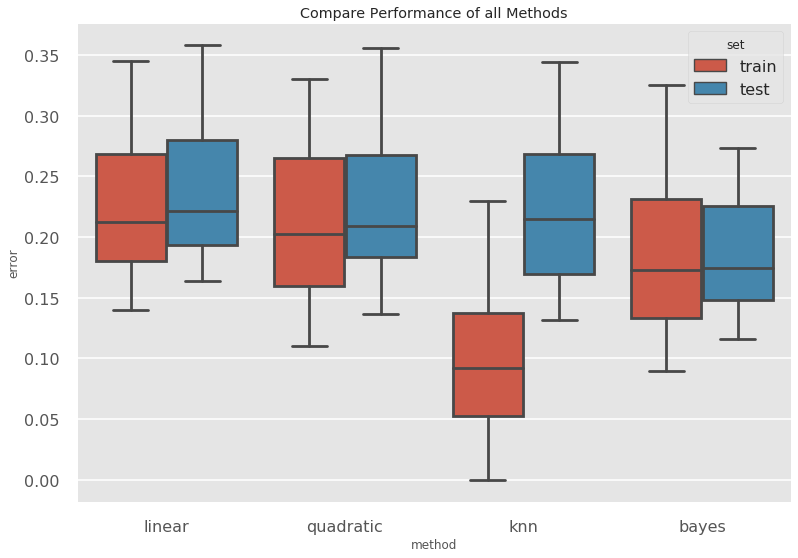

In [16]:
df = pd.DataFrame(classification_errors)

sns.set()
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

ax = sns.boxplot(x="method", y="error", hue="set", data=df).set_title('Compare Performance of all Methods')

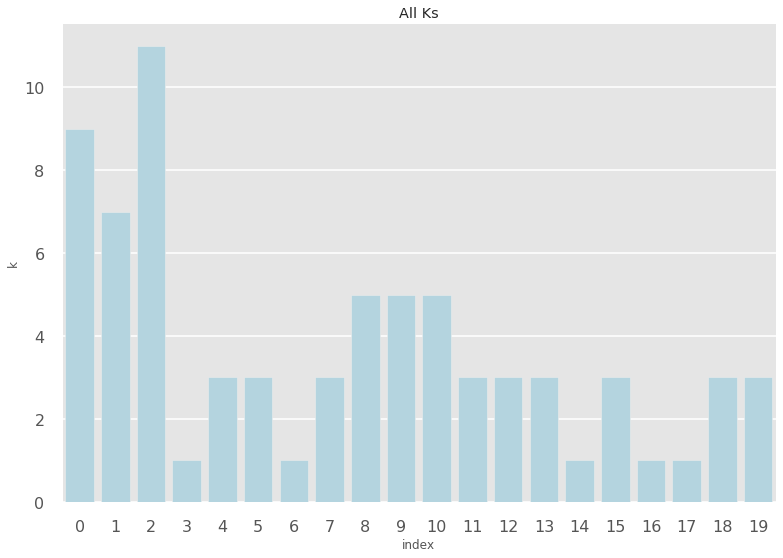

In [17]:
bestKdf = pd.DataFrame(list(zip(bestKs,range(len(bestKs)))),columns =['k','index'])
ax = sns.barplot(x='index',y='k',data=bestKdf,color='lightblue').set_title('All K''s')

In [20]:
print('Mean of best K''s: {}'.format(np.array(bestKs).mean()))

Mean of best Ks: 3.7


In [21]:
print('Standard Deviation of best K''s: {}'.format(np.array(bestKs).std()))

Standard Deviation of best Ks: 2.6286878856189833
